In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
import plotly
import plotly.graph_objs as go
import cufflinks as cf
cf.set_config_file(offline=True)

In [3]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [4]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [5]:
from models.CRNN import CRNN_model

# 1. Data

In [6]:
strategy = CommodityStrategy(strategy_name="CPM", asset_type="COMMODITY")
strategy.load_index_and_return(from_db=True, save_file=True)

strategy.index.columns.name = 'ticker'
strategy.ret.columns.name = 'ticker'

strategy.index.index.name = 'tdate'
strategy.ret.index.name = 'tdate'

strategy.index.drop_duplicates(inplace=True)
strategy.ret.drop_duplicates(inplace=True)

df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

2020-02-04 15:35:02,252 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:35:02,255 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:35:02,256 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:35:02,267 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:35:13,891 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:35:26,260 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:07,443 - CPM - INFO - [STEP 1 - 4] SAVE RETURN DATA INTO CSV FORMAT


In [7]:
df_index = strategy.index.loc[:'2019-07']
df_index_return = strategy.ret.loc[:'2019-07']

# 2. Explore

In [8]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

In [9]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

In [10]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 252]

# 1. FEATURE

### average return

In [11]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [12]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [13]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [14]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# 2. 성과

# CASE 0. 기존(머신러닝 사용 X)

In [15]:
from CPM import CPM

In [16]:
cpm = CPM(strategy_name="CPM", asset_type="COMMODITY")
cpm.load_index_and_return(from_db=True, save_file=True)
cpm.set_rebalance_period(ts_freq='week', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6 
cpm.calculate_signal(CS=0.35, minobs=52, longlen=52, shortlen=17)
cpm.set_portfolio_parameter(cs_strategy_type='vol')
cpm.make_portfolio()

2020-02-04 15:36:08,717 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:36:08,717 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:36:08,719 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:36:08,719 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:36:08,720 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:36:08,720 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:36:08,721 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:36:08,721 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:36:17,215 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:17,215 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:25,206 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:36:25,206 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:37:03,687 - CPM - INFO - [STEP 1 - 4] SAVE RETURN DATA I

In [17]:
start_date = '2011-01-01'
end_date = '2018-05-09'

# get r results
cpm_comp_df = pd.read_csv('../check/past/cpm.csv', header=0, index_col=0, parse_dates=True)
cpm_lag_comp_df = pd.read_csv('../check/past/cpm_lag.csv', header=0, index_col=0, parse_dates=True)

### 1. PYTHON & R

In [18]:
tester = Tester(cpm)
tester.set_period(start=start_date, end=end_date)
tester.run(save_file=False, use_bt=False)

2020-02-04 15:38:28,112 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:28,112 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:38:28,113 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:38:28,113 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:38:29,059 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL
2020-02-04 15:38:29,059 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL


In [19]:
to_plot = (1.+ cpm_lag_comp_df).loc[start_date:].cumprod()
to_plot['TS_python'] = tester.strategy.TS_result
to_plot['CS_python'] = tester.strategy.CS_result
to_plot.iplot()

# CASE 1. BINARY

- Binary로 나누어서 학습하고 상위 30% 하위 30% 롱숏

In [20]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 
df_index_y_binary = df_index_rank > df_index_rank.shape[1] / 2
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [21]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [22]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [23]:
def train_tree(train_x, train_y1, val_x, val_y1, max_depth=7, fraction=0.8, num_leaves=50, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, random_state=1, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': max_depth,
          'num_leaves': num_leaves,
          "learning_rate": learning_rate,
          "feature_fraction": fraction,
          "subsample": fraction,
          "verbosity": verbose,
          "metric": 'binary_logloss',
          'random_state': random_state
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [24]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_boost_round` in params. Will use it instead of argument



Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.692899	valid_1's binary_logloss: 0.69309
[20]	training's binary_logloss: 0.692649	valid_1's binary_logloss: 0.693032
[30]	training's binary_logloss: 0.692418	valid_1's binary_logloss: 0.693002
[40]	training's binary_logloss: 0.692184	valid_1's binary_logloss: 0.692975
[50]	training's binary_logloss: 0.691958	valid_1's binary_logloss: 0.692951
[60]	training's binary_logloss: 0.691722	valid_1's binary_logloss: 0.692914
[70]	training's binary_logloss: 0.691505	valid_1's binary_logloss: 0.692892
[80]	training's binary_logloss: 0.691278	valid_1's binary_logloss: 0.692868
[90]	training's binary_logloss: 0.691059	valid_1's binary_logloss: 0.692852
[100]	training's binary_logloss: 0.690828	valid_1's binary_logloss: 0.692819
[110]	training's binary_logloss: 0.690603	valid_1's binary_logloss: 0.692791
[120]	training's binary_logloss: 0.690383	valid_1's binary_logloss: 0.692766
[130]	training's binary_

In [25]:
%matplotlib inline

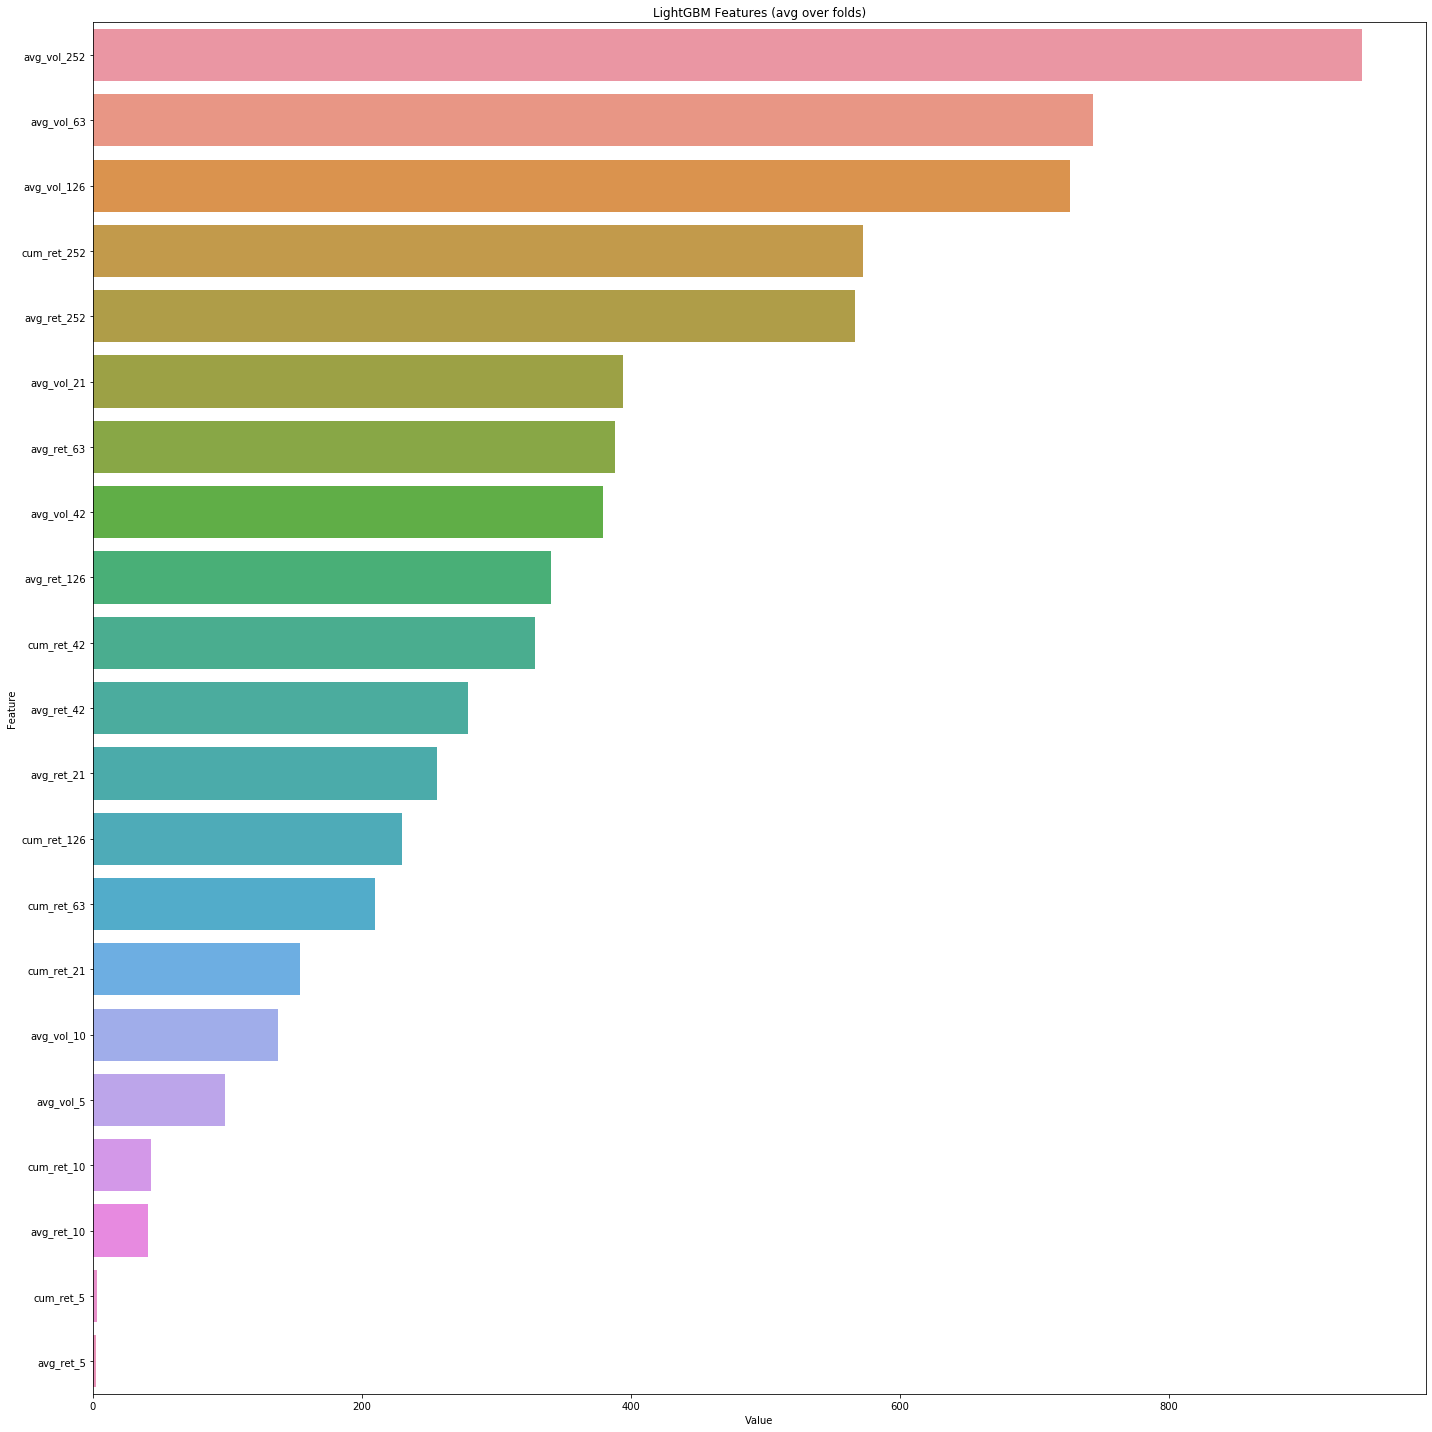

In [26]:
supply_demand_feature_imp = pd.DataFrame(sorted(zip(model.feature_importance(), df_train.columns[3:])), columns=['Value','Feature'])
plt.figure(figsize=(20, 20))
sns.barplot(x="Value", y="Feature", data=supply_demand_feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [27]:
test_pred = model.predict(df_test_x.values)

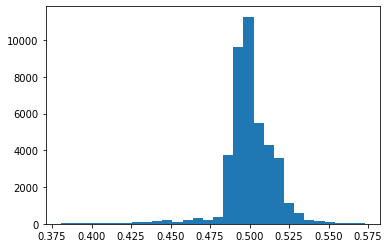

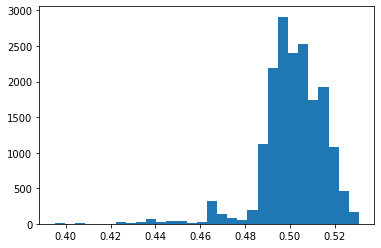

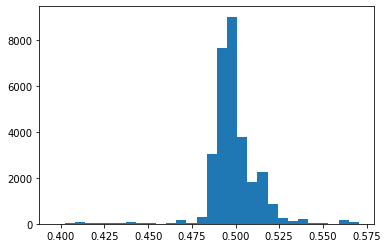

In [28]:
plt.hist(train_pred, bins=30)
plt.show()

plt.hist(val_pred, bins=30)
plt.show()

plt.hist(test_pred, bins=30)
plt.show()

### 결과

In [29]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')
df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [30]:
df_index_sub = df_index.loc['1994':]
long = df_pred.shape[1] / 10 * 7
short = df_pred.shape[1] / 10 * 3

df_pred_rank = df_pred.rank(axis=1)
df_pred_long = (df_pred_rank > long).astype(np.float32)
df_pred_short = (df_pred_rank < short).astype(np.float32)
df_pred_long_short = df_pred_long - df_pred_short
strategy.TSRV = df_pred_long_short
strategy.CSRV = df_pred_long_short

In [31]:
strategy.set_rebalance_period(ts_freq='week', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6 
strategy.set_portfolio_parameter(cs_strategy_type='vol')
strategy.make_portfolio()

2020-02-04 15:38:32,710 - CPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:38:32,710 - CPM - INFO - [STEP 2] SET REBALANCE PERIOD
2020-02-04 15:38:32,711 - CPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:38:32,711 - CPM - INFO - [STEP 4] SET PORTFOLIO PARAMETER
2020-02-04 15:38:32,712 - CPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:38:32,712 - CPM - INFO - [STEP 5] MAKE PORTFOLIO
2020-02-04 15:38:32,713 - CPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:38:32,713 - CPM - INFO - [STEP 5 - 1] CALCULATE VOLATILITY
2020-02-04 15:39:39,538 - CPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2020-02-04 15:39:39,538 - CPM - INFO - [STEP 5 - 2] MAKE TS POSITION
2020-02-04 15:39:39,539 - CPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2020-02-04 15:39:39,539 - CPM - INFO - [STEP 5 - 2 - 1] ALIGN TS POSITION WITH REBALANCE DAY
2020-02-04 15:39:41,164 - CPM - INFO - [STEP 5 - 2 - 2] TARGET VOL CONTROL to TS POSITION
2020-02-04 15:39:41,164 - CPM - 

### TEST

In [32]:
tester1 = Tester(strategy)
tester1.set_period(start=start_date, end=end_date)
tester1.run(use_bt=False)

2020-02-04 15:39:52,399 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:39:52,399 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:39:52,400 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:39:52,400 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:39:53,088 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL
2020-02-04 15:39:53,088 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL


In [33]:
to_plot['CS_ML'] = tester1.strategy.CS_result

In [34]:
to_plot.iplot()

# CASE 2. 70% 강조

- 상위 30%에 속하는 데이터와 하위 30%에 속하는 데이터로 학습한다.

In [35]:
one_month = 21
df_index_rank = df_index.pct_change(one_month).shift(-1 * one_month).rank(axis=1) 

In [36]:
df_index_y_binary1 = df_index_rank > df_index_rank.shape[1] / 3 * 2
df_index_y_binary1 = df_index_y_binary1.astype(np.float32)
df_y = df_index_y_binary1.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [37]:
df_join2 = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join2 = pd.merge(df_join2, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime('2005-12-31')]
df_val = df_join2.loc[(df_join2['tdate'] >= pd.to_datetime('2006-01-01')) & (df_join2['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join2.loc[df_join2['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [38]:
model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=i+1)

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.651326	valid_1's binary_logloss: 0.651722
[20]	training's binary_logloss: 0.650919	valid_1's binary_logloss: 0.651686
[30]	training's binary_logloss: 0.65049	valid_1's binary_logloss: 0.651669
[40]	training's binary_logloss: 0.650085	valid_1's binary_logloss: 0.651628
[50]	training's binary_logloss: 0.649669	valid_1's binary_logloss: 0.651594
[60]	training's binary_logloss: 0.649261	valid_1's binary_logloss: 0.651553
[70]	training's binary_logloss: 0.648842	valid_1's binary_logloss: 0.651534
[80]	training's binary_logloss: 0.64844	valid_1's binary_logloss: 0.651529
[90]	training's binary_logloss: 0.648047	valid_1's binary_logloss: 0.651519
[100]	training's binary_logloss: 0.647669	valid_1's binary_logloss: 0.651489
[110]	training's binary_logloss: 0.64728	valid_1's binary_logloss: 0.651476
[120]	training's binary_logloss: 0.646884	valid_1's binary_logloss: 0.651486
[130]	training's binary_lo

In [39]:
test_pred = model.predict(df_test_x.values)

In [40]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred
df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred2 = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

In [41]:
long = df_pred2.shape[1] / 10 * 7
short = df_pred2.shape[1] / 10 * 3
df_pred_rank2 = df_pred2.rank(axis=1)
df_pred_long2 = (df_pred_rank2 > long).astype(np.float32)
df_pred_short2 = (df_pred_rank2 < short).astype(np.float32)
df_pred_long_short2 = df_pred_long2 - df_pred_short2

In [42]:
strategy2 = CPM(strategy_name="CPM", asset_type="COMMODITY")
strategy2.load_index_and_return(from_db=True, save_file=True)
strategy2.set_rebalance_period(ts_freq='week', cs_freq='week', rebalance_weekday=1)  # rebalance_day: monday = 0, sunday = 6 
strategy2.TSRV = df_pred_long_short2
strategy2.CSRV = df_pred_long_short2
strategy2.set_portfolio_parameter(cs_strategy_type='vol')
strategy2.make_portfolio()

2020-02-04 15:39:55,600 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:39:55,600 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:39:55,600 - CPM - INFO - [STEP 0] START LOGGING CPM
2020-02-04 15:39:55,602 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:55,602 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:55,602 - CPM - INFO - [STEP 1] LOAD DATA
2020-02-04 15:39:55,604 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:55,604 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:55,604 - CPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2020-02-04 15:39:55,605 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:39:55,605 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:39:55,605 - CPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM DATABASE
2020-02-04 15:40:09,697 - CPM - INFO - [STEP 1 - 3] CHANGE BLOOM DATA INTO STANDARD FORMAT
2020-02-04 15:40:09,697 - CPM - INFO - [STEP 1 - 3] CHANGE B

### TEST

In [43]:
tester2 = Tester(strategy2)
tester2.set_period(start=start_date, end=end_date)
tester2.run(use_bt=False)

2020-02-04 15:42:36,362 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:42:36,362 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:42:36,362 - CPM - INFO - [STEP 6] START BACKTEST
2020-02-04 15:42:36,363 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:42:36,363 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:42:36,363 - CPM - INFO - [STEP 6 - 1] BACKTEST CPM TIME SERIES
2020-02-04 15:42:36,917 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL
2020-02-04 15:42:36,917 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL
2020-02-04 15:42:36,917 - CPM - INFO - [STEP 6 - 2] BACKTEST CPM CROSS SECTIONAL


In [44]:
to_plot['CS_ML_UPPER'] = tester2.strategy.CS_result

In [45]:
to_plot.iplot()

In [46]:
result = pd.concat([empm.CS_summary,
                    empm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary], axis=1)

NameError: name 'empm' is not defined

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER']

# CASE 3. Case1을 Rolling으로 실행

In [ ]:
val_rolling_one_year = ['2007-12-31',
                    '2008-12-31',
                    '2009-12-31',
                    '2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31']

In [ ]:
test_rolling_one_year = ['2010-12-31',
                    '2011-12-31',
                    '2012-12-31',
                    '2013-12-31',
                    '2014-12-31',
                    '2015-12-31',
                    '2016-12-31',
                    '2017-12-31',
                    '2018-12-31']

In [ ]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [ ]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join.loc[df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join.loc[(df_join['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join.loc[(df_join['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

In [ ]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

In [ ]:
plt.hist(df_test_concat['y_pred'], bins=30)

In [ ]:
long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

df_pred_rank3 = df_test_pred.rank(axis=1)
df_pred_long3 = (df_pred_rank3 > long).astype(np.float32)
df_pred_short3 = (df_pred_rank3 < short).astype(np.float32)
df_pred_long_short3 = df_pred_long3 - df_pred_short3

In [ ]:
strategy3 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy3.load_index_and_return(from_db=False, save_file=False)
strategy3.index.drop_duplicates(inplace=True)
strategy3.ret.drop_duplicates(inplace=True)

In [ ]:
strategy3.TSRV = df_pred_long_short3
strategy3.CSRV = df_pred_long_short3

strategy3.set_rebalance_period(freq='month') 
strategy3.set_portfolio_parameter(cs_strategy_type='notional')
strategy3.make_portfolio()

In [ ]:
tester3 = Tester(strategy3)
tester3.set_period(start=start_date, end=end_date)
tester3.run()

In [ ]:
to_plot['CS_ML_ROLLING'] = tester3.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary], axis=1)

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING']

In [ ]:
result

# CASE 4. CASE 2를 ROLLING으로 실행

In [ ]:
models = []
train_preds = []
val_preds = []
test_preds = []

In [ ]:
for i, one_year in enumerate(val_rolling_one_year):
    df_train = df_join2.loc[df_join2['tdate'] <= pd.to_datetime(val_rolling_one_year[i])]
    
    if i == len(val_rolling_one_year) - 1:
        df_test = df_join2.loc[df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i])]
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                     (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
    else:
        df_val = df_join2.loc[(df_join2['tdate'] > pd.to_datetime(val_rolling_one_year[i])) & 
                             (df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i]))]
        
        df_test = df_join2.loc[(df_join2['tdate'] <= pd.to_datetime(test_rolling_one_year[i+1])) & 
                              (df_join2['tdate'] > pd.to_datetime(test_rolling_one_year[i]))]

    df_train_y = df_train['y']
    df_train_x = df_train[df_train.columns[3:]]
    
    df_val_y = df_val['y']
    df_val_x = df_val[df_val.columns[3:]]

    df_test_y = df_test['y']
    df_test_x = df_test[df_test.columns[3:]]
    
    model, train_pred, val_pred = train_tree(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                         max_depth=5, num_leaves=20, fraction=0.6,
                                         num_boost_round=10000, 
                                         learning_rate=0.001, 
                                         verbose=10,
                                         early_stopping_rounds=100,
                                         random_state=0)
    test_pred = model.predict(df_test_x.values)
    df_train['y_pred'] = train_pred
    df_val['y_pred'] = val_pred
    df_test['y_pred'] = test_pred
    
    models.append(model)
    train_preds.append(df_train)
    val_preds.append(df_val)
    test_preds.append(df_test)

In [ ]:
df_test_concat = pd.concat(test_preds, axis=0)
df_test_pred = pd.pivot_table(df_test_concat, columns='ticker', index='tdate', values='y_pred')

long = df_test_pred.shape[1] / 10 * 7
short = df_test_pred.shape[1] / 10 * 3

In [ ]:
df_pred_rank4 = df_test_pred.rank(axis=1)
df_pred_long4 = (df_pred_rank4 > long).astype(np.float32)
df_pred_short4 = (df_pred_rank4 < short).astype(np.float32)
df_pred_long_short4 = df_pred_long4 - df_pred_short4

In [ ]:
strategy4 = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")
strategy4.load_index_and_return(from_db=False, save_file=False)
strategy4.index.drop_duplicates(inplace=True)
strategy4.ret.drop_duplicates(inplace=True)

In [ ]:
strategy4.TSRV = df_pred_long_short4
strategy4.CSRV = df_pred_long_short4

strategy4.set_rebalance_period(freq='month') 
strategy4.set_portfolio_parameter(cs_strategy_type='notional')
strategy4.make_portfolio()

In [ ]:
tester4 = Tester(strategy4)
tester4.set_period(start=start_date, end=end_date)
tester4.run(use_bt=False)

In [ ]:
to_plot['CS_ML_UPPER_ROLLING'] = tester4.strategy.CS_result

In [ ]:
to_plot.iplot()

In [ ]:
result = pd.concat([epm.CS_summary,
                    epm.TS_summary,
                    strategy.CS_summary,
                    strategy2.CS_summary,
                    strategy3.CS_summary,
                    strategy4.CS_summary], axis=1)

In [ ]:
result

In [ ]:
result.columns = ['CS_python', 'TS_python', 'CS_ML', 'CS_ML_UPPER', 'CS_ML_ROLLING', 'CS_ML_UPPER_ROLING']

In [ ]:
result